In [1]:
import os
import matplotlib.pyplot as plt
import pims
import sys
import numpy as np
sys.path.insert(0,'/home/jmamede/scripts')
# from support_pla import othercolor, cell_mask, multiply, rebin
from support_pla import cellpose_mask,cellpose_model
import pandas as pd
from nd2reader import ND2Reader
import glob
import csv
plot = True

In [2]:
# ficheiro = "/run/media/jmamede/Joao/96wells/20201119_143803_601/WellA01_ChannelGFP,DAPI_Seq0000.nd2"
dirname = '/home/jmamede/Data/tests/Well*.nd2'
filelist = glob.glob(dirname)
filelist.sort()


# reader = ND2Reader(ficheiro)
# print(reader.sizes)

# metadata = reader.metadata
# reader.bundle_axes = 'cyx'
# reader.iter_axes = 'z'
# #there is a bug, it reads each visit point as a Z.
# reader.default_coords['v'] = 0
# #reader.sizes['z']

def plots(reader,cells_masks,nuclei_masks,base,series):
    %matplotlib inline
    from cellpose.utils import masks_to_outlines
    f, axarr = plt.subplots(3)
    print(axarr.shape)
    axarr[0].imshow(reader[series][1],vmin=np.min(reader[5][1]),vmax=np.max(reader[5][1])/2
#         ,cmap="gray"
                     )
    axarr[0].imshow(masks_to_outlines(cells_masks),alpha=0.6,cmap='gray'
        )
#     axarr[0,2].imshow(reader[i][0],vmin=100,vmax=np.max(reader[5][0])/3
#         )
    axarr[2].imshow(reader[series][1],vmin=np.min(reader[5][1]),vmax=np.max(reader[5][1])/2
#         ,cmap="gray"
                     )
    axarr[2].imshow(cells_masks,alpha=0.4,cmap='jet')
    
    axarr[1].imshow(reader[series][0],vmin=np.min(reader[5][0]),vmax=np.max(reader[5][0])/2
#                       ,cmap="gray"
        )
    axarr[1].imshow(masks_to_outlines(nuclei_masks),alpha=0.4,cmap='gray')
        
        
#     axarr[1,2].imshow(reader[i][1],vmin=100,vmax=np.max(reader[5][0])/3
#         )
#     axarr[1,2].imshow(nuclei_masks
# #                 ,alpha=0.6
#         )
    plt.savefig(base+'v'+str(series),dpi=600)
    return f,axarr




In [3]:
import contextlib
import io
from cellpose import io as iocp
from cellpose import plot,utils
    
    
    
model = cellpose_model(GPU=True)
model_nuc = cellpose_model(GPU=True,model_type='nuclei')

f = open("/home/jmamede/Data/analysis2.csv", 'wt')
output = csv.writer(f
#                     , delimiter=',',
#                             quotechar='"', quoting=csv.QUOTE_MINIMAL
                   )
output.writerow(["Well","VisitPoint","num_cells","infected_cells","percentage"])

f2 = open("/home/jmamede/Data/analysisWells.csv", 'wt')
output2 = csv.writer(f2
#                     , delimiter=',',
#                             quotechar='"', quoting=csv.QUOTE_MINIMAL
                   )
output2.writerow(["Well","VisitPoint","num_cells","infected_cells","percentage"])

from napari.qt import thread_worker

# for ficheiro in filelist:
# @thread_worker
def poseri(ficheiro,chan_cells,chan_nuclei):
    from cellpose import io as iocp
    from cellpose import plot,utils
    reader = ND2Reader(ficheiro)
#     metadata = reader.metadata
    reader.bundle_axes = 'cyx'
    reader.iter_axes = 'z'
    #there is a bug, it reads each visit point as a Z.
    reader.default_coords['v'] = 0
    ncells = 0
    nnuclei = 0
    
#     for i in range(reader.sizes['z']):
    for i in [0]:
        #shut cellpose messages up.
        with contextlib.redirect_stdout(io.StringIO()):
            
            cells_masks = cellpose_mask(reader[i][chan_cells],model
            #                             ,size=2500
                                        ,flow_threshold=0.8,size=0,diam=50,cell_prob=-1
                                       )
            nuclei_masks = cellpose_mask(reader[i][chan_nuclei],model_nuc
            #                             ,size=2500
                                        ,flow_threshold=1.2,size=0,diam=25,cell_prob=0
                                       )
            ncells += cells_masks.max()
            nnuclei += nuclei_masks.max()
            base = os.path.splitext(ficheiro)[0]
            outlines = utils.outlines_list(cells_masks)
            cell_outlines = utils.masks_to_outlines(cells_masks)
            iocp.outlines_to_text(base+'v'+str(i), outlines)
            f,axarr =  plots(reader,cells_masks,nuclei_masks,base,i)
    
        text = "Image#: {0} Number of Nuclei: {1} Number of positive cells: {2} Percentage: {3}".format(i,nuclei_masks.max(),cells_masks.max(),cells_masks.max()/nuclei_masks.max())
        print(ficheiro,text)
#         output.writerow([ficheiro,i,nuclei_masks.max(),cells_masks.max(),cells_masks.max()/nuclei_masks.max()*100])
#     output2.writerow(([ficheiro,'NA',nnuclei,ncells,ncells/nnuclei*100]))
    return [reader[i][chan_cells],reader[i][chan_nuclei],cells_masks,nuclei_masks]
f.close()

** CUDA version installed and working. **
>>>> using GPU
cellpose_residual_on_style_on_concatenation_off
** CUDA version installed and working. **
>>>> using GPU
cellpose_residual_on_style_on_concatenation_off


/home/jmamede/anaconda3/lib/python3.7/site-packages/napari/__init__.py:44: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.9.7. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


/home/jmamede/anaconda3/lib/python3.7/site-packages/nd2reader/raw_metadata.py:171: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/home/jmamede/Data/tests/WellA01_Channela647,GFP,mRuby_Seq0000.nd2 Image#: 0 Number of Nuclei: 167 Number of positive cells: 28 Percentage: 0.16766467065868262


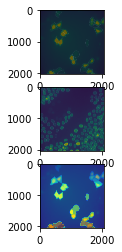

In [4]:
result = poseri(filelist[0],1,0)

In [5]:
result

[Frame([[803., 864., 850., ..., 801., 930., 854.],
        [956., 835., 807., ..., 817., 922., 921.],
        [894., 896., 854., ..., 949., 859., 895.],
        ...,
        [923., 876., 858., ..., 827., 881., 857.],
        [873., 878., 861., ..., 824., 858., 847.],
        [878., 842., 809., ..., 911., 824., 850.]]),
 Frame([[445., 462., 439., ..., 260., 291., 252.],
        [496., 463., 453., ..., 243., 275., 245.],
        [434., 448., 456., ..., 276., 238., 292.],
        ...,
        [275., 254., 308., ..., 532., 499., 483.],
        [280., 301., 301., ..., 519., 474., 536.],
        [244., 286., 304., ..., 520., 498., 479.]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..

In [6]:
# import numpy as np
# import napari
# import time
# from dask import delayed
# import dask.array as da

# def outputfiles(ficheiro):
#     from nd2reader import ND2Reader
#     reader = ND2Reader(ficheiro)
# #     metadata = reader.metadata
#     reader.bundle_axes = 'cyx'
#     reader.iter_axes = 'z'
#     #there is a bug, it reads each visit point as a Z.
#     reader.default_coords['v'] = 0
#     return reader
    
# a = outputfiles(filelist[0])
# a[0].dtype
# lazy_imread = delayed(outputfiles)
# lazy_arrays = [lazy_imread(fn) for fn in filelist]
    
# lazy_imread = delayed(outputfiles)
# # lazy_arrays = [lazy_imread(fn) for fn in filelist]
# lazy_arrays = [lazy_imread(filelist[0])]

# dask_arrays = [da.from_delayed(delayed_reader,shape=(3,2044,2048),dtype='float64') for delayed_reader in lazy_arrays]

In [ ]:
import napari
from napari.qt import thread_worker
from cellpose.utils import masks_to_outlines
with napari.gui_qt():
    v = napari.Viewer(show=False)
    v.show()
    #     layer = viewer.add_image(np.random.random((512, 512)))
#     @thread_worker
    def updating(result):
    #         v.layers.remove('image')
        from cellpose.utils import masks_to_outlines
        [v.layers.pop(0) for la in range(len(v.layers))]    

        v.add_image(
            result[1],
            blending='additive',
    #         contrast_limits=[np.min(result[1]),np.max(result[1])],
    #         ndisplay=2,
            colormap='blue',
            name='nuclei'
        )   

        v.add_image(
            result[0],
            blending='additive',
            colormap='green',
            name='cells')

        v.add_labels(
        result[2],
        opacity=0.4,
        blending='additive',
    #         contrast_limits=[np.min(result[1]),np.max(result[1])],
        name='nuclei'
        ) 

        v.add_labels(
        masks_to_outlines(result[3]),
    #     utils.outlines_list(result[0]),
        opacity=0.4,
        blending='additive',
    #         contrast_limits=[np.min(result[1]),np.max(result[1])],
        name='nuclei'
        )
#         yield

        

    for ficheiro in filelist:
        result = poseri(ficheiro,1,0)
        updating(result)
#         worker.start

    #     layers[0].data = []
    #     layers[1].data = []
    #     layers[0] = []
    #     layers[0] = []

/home/jmamede/anaconda3/lib/python3.7/site-packages/nd2reader/raw_metadata.py:171: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/home/jmamede/Data/tests/WellA01_Channela647,GFP,mRuby_Seq0000.nd2 Image#: 0 Number of Nuclei: 167 Number of positive cells: 28 Percentage: 0.16766467065868262


/home/jmamede/anaconda3/lib/python3.7/site-packages/nd2reader/raw_metadata.py:171: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/home/jmamede/Data/tests/WellA02_Channela647,GFP,mRuby_Seq0001.nd2 Image#: 0 Number of Nuclei: 242 Number of positive cells: 18 Percentage: 0.0743801652892562


/home/jmamede/anaconda3/lib/python3.7/site-packages/nd2reader/raw_metadata.py:171: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/home/jmamede/Data/tests/WellB01_Channela647,GFP,mRuby_Seq0019.nd2 Image#: 0 Number of Nuclei: 231 Number of positive cells: 10 Percentage: 0.04329004329004329


/home/jmamede/anaconda3/lib/python3.7/site-packages/nd2reader/raw_metadata.py:171: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/home/jmamede/Data/tests/WellB02_Channela647,GFP,mRuby_Seq0018.nd2 Image#: 0 Number of Nuclei: 298 Number of positive cells: 7 Percentage: 0.02348993288590604


/home/jmamede/anaconda3/lib/python3.7/site-packages/nd2reader/raw_metadata.py:171: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/home/jmamede/Data/tests/WellB03_Channela647,GFP,mRuby_Seq0017.nd2 Image#: 0 Number of Nuclei: 288 Number of positive cells: 5 Percentage: 0.017361111111111112


/home/jmamede/anaconda3/lib/python3.7/site-packages/nd2reader/raw_metadata.py:171: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/home/jmamede/Data/tests/WellB04_Channela647,GFP,mRuby_Seq0016.nd2 Image#: 0 Number of Nuclei: 283 Number of positive cells: 9 Percentage: 0.03180212014134275


/home/jmamede/anaconda3/lib/python3.7/site-packages/nd2reader/raw_metadata.py:171: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/home/jmamede/Data/tests/WellB05_Channela647,GFP,mRuby_Seq0015.nd2 Image#: 0 Number of Nuclei: 311 Number of positive cells: 11 Percentage: 0.03536977491961415


/home/jmamede/anaconda3/lib/python3.7/site-packages/nd2reader/raw_metadata.py:171: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/home/jmamede/Data/tests/WellB06_Channela647,GFP,mRuby_Seq0014.nd2 Image#: 0 Number of Nuclei: 286 Number of positive cells: 11 Percentage: 0.038461538461538464


/home/jmamede/anaconda3/lib/python3.7/site-packages/nd2reader/raw_metadata.py:171: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/home/jmamede/Data/tests/WellB07_Channela647,GFP,mRuby_Seq0013.nd2 Image#: 0 Number of Nuclei: 298 Number of positive cells: 10 Percentage: 0.03355704697986577


/home/jmamede/anaconda3/lib/python3.7/site-packages/nd2reader/raw_metadata.py:171: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/home/jmamede/Data/tests/WellB08_Channela647,GFP,mRuby_Seq0012.nd2 Image#: 0 Number of Nuclei: 291 Number of positive cells: 15 Percentage: 0.05154639175257732


/home/jmamede/anaconda3/lib/python3.7/site-packages/nd2reader/raw_metadata.py:171: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/home/jmamede/Data/tests/WellB09_Channela647,GFP,mRuby_Seq0011.nd2 Image#: 0 Number of Nuclei: 282 Number of positive cells: 3 Percentage: 0.010638297872340425


/home/jmamede/anaconda3/lib/python3.7/site-packages/nd2reader/raw_metadata.py:171: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/home/jmamede/Data/tests/WellB10_Channela647,GFP,mRuby_Seq0010.nd2 Image#: 0 Number of Nuclei: 11 Number of positive cells: 10 Percentage: 0.9090909090909091


/home/jmamede/anaconda3/lib/python3.7/site-packages/nd2reader/raw_metadata.py:171: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/home/jmamede/Data/tests/WellC01_Channela647,GFP,mRuby_Seq0020.nd2 Image#: 0 Number of Nuclei: 272 Number of positive cells: 9 Percentage: 0.03308823529411765


/home/jmamede/anaconda3/lib/python3.7/site-packages/nd2reader/raw_metadata.py:171: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/home/jmamede/Data/tests/WellD01_Channela647,GFP,mRuby_Seq0039.nd2 Image#: 0 Number of Nuclei: 230 Number of positive cells: 10 Percentage: 0.043478260869565216


/home/jmamede/anaconda3/lib/python3.7/site-packages/nd2reader/raw_metadata.py:171: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


In [7]:
import time
import numpy as np
import napari

from qtpy.QtCore import Qt
from qtpy.QtWidgets import QPushButton


image = np.random.random((2048, 2048))
zeros = np.zeros((2048, 2048))

@thread_worker
def pan(layer, interval=0.05):
    layer.translate = (-2148, 0)
    layer.data = image
    for i in range(-2140, 8, 16):
        layer.translate = (i, 0)
        yield
        time.sleep(interval)

with napari.gui_qt():
    v = napari.Viewer(show=False)
    v.window._qt_window.setWindowState(Qt.WindowMaximized)
    v.show()

    image_layer = v.add_image(zeros)
    worker = pan(image_layer)

    button = QPushButton("Start animation")
    button.clicked.connect(worker.start)
    v.window.add_dock_widget(widget=button, area='left')

NameError: name 'masks_to_outlines' is not defined

In [30]:
with napari.gui_qt():
    viewer = napari.Viewer()

    @thread_worker(connect={"returned": viewer.add_image})
    def average_large_image():
        return np.random.rand(1024, 512, 512).mean(0)

    average_large_image()

In [7]:
import napari
with napari.gui_qt():
    v = napari.view_image(result[0])

/home/jmamede/anaconda3/lib/python3.7/site-packages/napari/__init__.py:44: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.9.7. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


In [ ]:
from numba import cuda
cuda.select_device(0)
cuda.close()
cuda.select_device(0)

In [ ]:
from cellpose.utils import 

plt.imshow(masks_to_outlines(cells_masks))